In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Parameters for cross-validation and scoring
cv_folds = 5
scoring_metric = {'accuracy': 'accuracy', 'recall': 'recall'}  # Multi-metric scoring

# Load the dataset
df = pd.read_csv('wdbc.csv')

# Replacing 'M' with 1 and 'B' with 0 in the 'diagnosis' column
df['Diagnosis'] = df['Diagnosis'].replace({'M': 1, 'B': 0})

# Move the 'Diagnosis' column to the last position and remove the 'ID' column
cols = list(df.columns)
cols.remove('Diagnosis')
cols.remove('ID')
df = df[cols + ['Diagnosis']]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Split the dataset into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit and transform the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the classifiers and their parameter grids
classifiers = {
    'Random Forest': (RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'min_samples_split': [2, 5, 10], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy']}),
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=100000), {'C': [0.1, 1, 10, 100], 'penalty': ['l2'], 'fit_intercept': [True, False], 'solver': ['lbfgs', 'liblinear'], 'warm_start': [True, False]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance'], 'p': [1, 2]}),
    'SVM': (SVC(random_state=42), {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'decision_function_shape': ['ovo', 'ovr']}),
    'Perceptron': (Perceptron(random_state=42), {'alpha': [0.0001, 0.001, 0.01], 'fit_intercept': [True, False], 'shuffle': [True, False], 'early_stopping': [True, False]})
}

# Perform GridSearchCV for each classifier on the training set
best_models = {}
for name, (classifier, param_grid) in classifiers.items():
    grid_search = GridSearchCV(classifier, param_grid, cv=cv_folds, scoring=scoring_metric, refit='accuracy', verbose=1)  # Multi-metric evaluation
    grid_search.fit(X_train, y_train)  # Fit the model on the training set

    # Store the best model
    best_models[name] = grid_search.best_estimator_

    # Output the best parameters and cross-validation accuracy
    print(f" {name}:")
    print(f"   Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
    print(f"   Best Parameters: {grid_search.best_params_}")

    # Show additional evaluation metrics from GridSearchCV
    for metric in scoring_metric.keys():
        mean_score = max(grid_search.cv_results_[f'mean_test_{metric}'])
        print(f"   Best {metric.capitalize()}: {mean_score:.4f}")



<ipython-input-5-3df7c0270383>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Diagnosis'] = df['Diagnosis'].replace({'M': 1, 'B': 0})


Fitting 5 folds for each of 24 candidates, totalling 120 fits
 Random Forest:
   Best Cross-Validation Accuracy: 0.9573
   Best Parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
   Best Accuracy: 0.9573
   Best Recall: 0.9260
Fitting 5 folds for each of 32 candidates, totalling 160 fits
 Logistic Regression:
   Best Cross-Validation Accuracy: 0.9774
   Best Parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
   Best Accuracy: 0.9774
   Best Recall: 0.9662
Fitting 5 folds for each of 28 candidates, totalling 140 fits
 KNN:
   Best Cross-Validation Accuracy: 0.9622
   Best Parameters: {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
   Best Accuracy: 0.9622
   Best Recall: 0.9262
Fitting 5 folds for each of 24 candidates, totalling 120 fits
 SVM:
   Best Cross-Validation Accuracy: 0.9748
   Best Parameters: {'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
   Bes

In [ ]:
# Initialize an empty dictionary to store test metrics for each model
results = {}

# Assuming `best_models` and test datasets `X_test` and `y_test` are defined
for name, model in best_models.items():
    y_pred = model.predict(X_test)  # Make predictions on the test set
    test_accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy on the test set
    test_recall = recall_score(y_test, y_pred)  # Calculate recall on the test set
    test_f1 = f1_score(y_test, y_pred)  # Calculate F1 score on the test set

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': test_accuracy,
        'recall': test_recall,
        'f1_score': test_f1,
        'confusion_matrix': cm
    }

# Convert results to a pandas DataFrame
results_df = pd.DataFrame({
    model: {
        'Accuracy': metrics['accuracy'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score']
    }
    for model, metrics in results.items()
}).T

# Display the results as a table
results_df

,Accuracy,Recall,F1 Score
Random Forest,0.970760,0.936508,0.959350
Logistic Regression,0.994152,0.984127,0.992000
KNN,0.959064,0.920635,0.943089
SVM,0.982456,0.968254,0.976000
Perceptron,0.970760,0.984127,0.961240


[[104   4]
 [  1  62]]


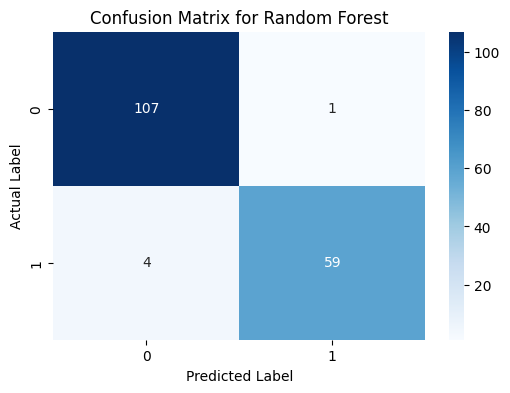

[[107   1]
 [  4  59]]


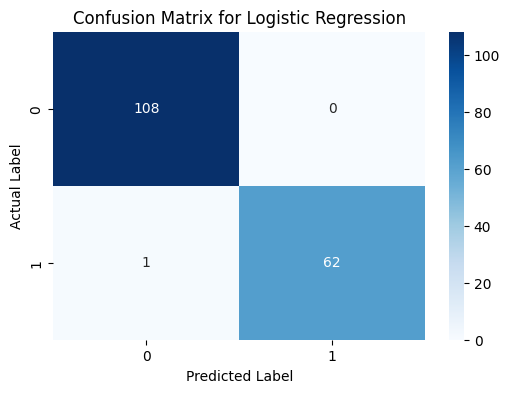

[[108   0]
 [  1  62]]


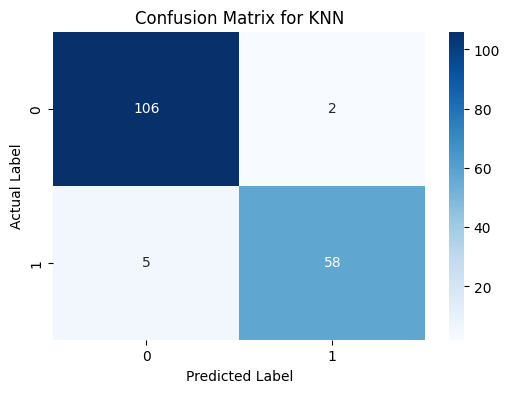

[[106   2]
 [  5  58]]


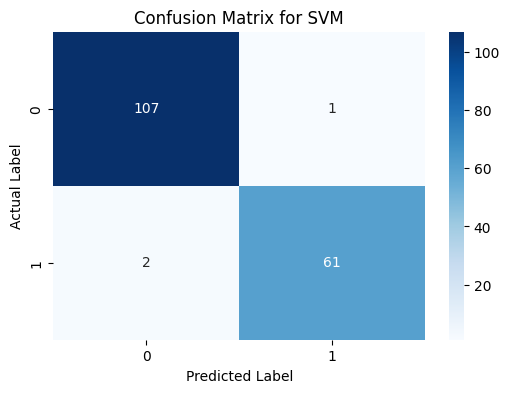

[[107   1]
 [  2  61]]


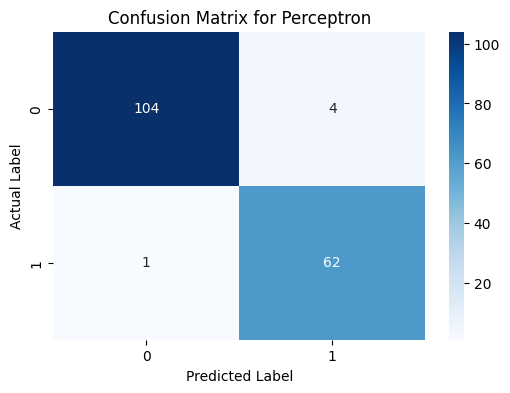

In [ ]:
# Visualize the confusion matrices
for name, metrics in results.items():
    print(cm)
    cm = metrics['confusion_matrix']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()

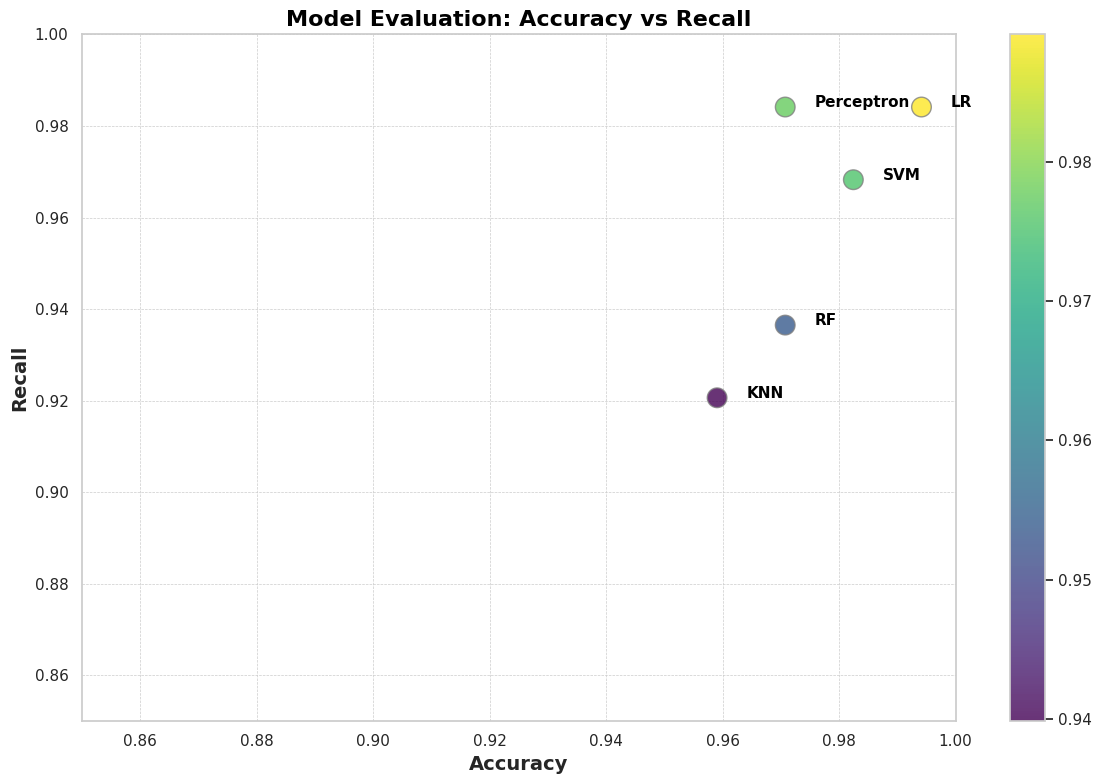

In [ ]:
# Rename specific model names in the results dictionary
results_renamed = {model.replace("Logistic Regression", "LR").replace("Random Forest", "RF"): metrics
                   for model, metrics in results.items()}

# Replace the original 'results' dictionary with the renamed one
results = results_renamed

# Extract model names, accuracies, and recalls
models = list(results.keys())
accuracies = [results[model]['accuracy'] for model in models]
recalls = [results[model]['recall'] for model in models]

# Calculate a combined score (e.g., average of accuracy and recall) to determine color intensity
combined_scores = np.array([0.5 * (acc + rec) for acc, rec in zip(accuracies, recalls)])

# Using a perceptually uniform colormap (viridis)
cmap = plt.cm.viridis

# Create a scatter plot with improved aesthetics
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Scatter plot
scatter = plt.scatter(accuracies, recalls, c=combined_scores, cmap=cmap, s=200, edgecolor='gray', alpha=0.8)

# Annotate points with model names
for i, model in enumerate(models):
    plt.text(accuracies[i] + 0.005, recalls[i], model, fontsize=11, fontweight='bold', color='black')

# Set plot labels and title
plt.xlabel('Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Recall', fontsize=14, fontweight='bold')
plt.title('Model Evaluation: Accuracy vs Recall', fontsize=16, fontweight='bold', color='black')

# Add gridlines and limits
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5)
plt.xlim(0.85, 1.0)
plt.ylim(0.85, 1.0)

# Add a colorbar to show combined scores
cbar = plt.colorbar(scatter)

# Show the plot
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.colors as mcolors

# Rename specific model names in the results dictionary
results_renamed = {model.replace("Logistic Regression", "LR").replace("Random Forest", "RF"): metrics
                   for model, metrics in results.items()}

# Replace the original 'results' dictionary with the renamed one
results = results_renamed


# Extract model names, accuracies, and recalls
models = list(results.keys())
accuracies = [results[model]['accuracy'] for model in models]
recalls = [results[model]['recall'] for model in models]

# Calculate a combined score (e.g., average of accuracy and recall) to determine color intensity
combined_scores = np.array([0.5 * (acc + rec) for acc, rec in zip(accuracies, recalls)])

# Create a custom colormap from light blue to soft green
colors = ["#A1D6E2", "#199C80"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("CustomGradient", colors)

# Create a scatter plot with improved aesthetics
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6.5))

# Scatter plot
scatter = plt.scatter(accuracies, recalls, c=combined_scores, cmap=custom_cmap, s=200, edgecolor='gray', alpha=0.8)

# Annotate points with model names, repositioning text to avoid overlapping with the colorbar
for i, model in enumerate(models):
    x_offset = 0.004 if accuracies[i] > 0.92 else 0.01  # Adjust horizontal position dynamically
    y_offset = 0.003  # Slight vertical offset
    plt.text(accuracies[i] + x_offset, recalls[i] + y_offset, model,
             fontsize=11, fontweight='bold', color='black', ha='center')

# Set plot labels and title
plt.xlabel('Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Recall', fontsize=14, fontweight='bold')
plt.title('Model Evaluation: Accuracy vs Recall', fontsize=16, fontweight='bold', color='black')

# Add gridlines and limits
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5)
plt.xlim(0.90, 1.0)
plt.ylim(0.90, 1.0)

# Add a colorbar to show combined scores
cbar = plt.colorbar(scatter)

# Adjust layout to ensure proper spacing for annotations
plt.tight_layout()
plt.show()



NameError: name 'results' is not defined

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# Assuming `best_models` is a dictionary with 'Random Forest' as a key
random_forest = best_models['Random Forest']

# Evaluate individual tree accuracy
tree_accuracies = []
for i, tree in enumerate(random_forest.estimators_):
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)  # Calculate individual tree accuracy
    tree_accuracies.append((i, acc))

# Find tree closest to overall Random Forest accuracy
ensemble_pred = random_forest.predict(X_test)
overall_accuracy = accuracy_score(y_test, ensemble_pred)
best_tree_idx, best_tree_acc = min(tree_accuracies, key=lambda x: abs(x[1] - overall_accuracy))
print(f"Tree {best_tree_idx} is closest to the ensemble accuracy with accuracy: {best_tree_acc:.4f}")

# Get tree depth for simplicity
tree_depths = [tree.get_depth() for tree in random_forest.estimators_]
simplest_tree_idx = np.argmin(tree_depths)
print(f"Tree {simplest_tree_idx} is the simplest with depth {tree_depths[simplest_tree_idx]}.")

# Choose based on simplicity (simplest tree)
single_tree = random_forest.estimators_[simplest_tree_idx]

Tree 24 is closest to the ensemble accuracy with accuracy: 0.9649
Tree 25 is the simplest with depth 4.


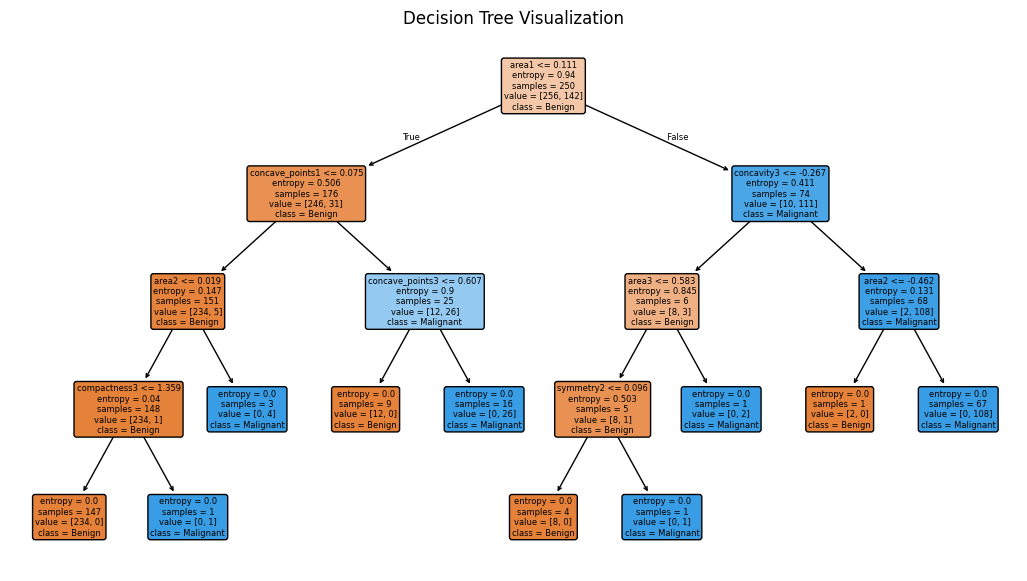

In [ ]:
import pandas as pd

# Assuming you have the original feature names from the dataset
feature_names = X.columns  # Replace with your original feature names if different
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Visualize the simplest tree
plt.figure(figsize=(13, 7))
plot_tree(single_tree,
          feature_names=X_test_df.columns,  # Use feature names from the DataFrame
          class_names=['Benign', 'Malignant'],  # Specify class names
          filled=True,
          rounded=True)
plt.title(f"Decision Tree Visualization")
plt.show()
